# Kickstarter Machine Learning Project

In [1]:
"""
From Ahmad:
I would suggest to try multiple models for classification
and regression and compare them to make your project more
significant. Also focus a bit more on the EDA part and try
to make an interesting analysis with nice visualisations.
There could be interesting questions which could be answered
by your analysis, eg: which category of the projects have a
higher success rate. Also if this data-set was already used
in a kaggle competition, you can also report and compare your
accuracy with the accuracy of the wining team of the
competition in kaggle.
"""

'\nFrom Ahmad:\nI would suggest to try multiple models for classification\nand regression and compare them to make your project more\nsignificant. Also focus a bit more on the EDA part and try\nto make an interesting analysis with nice visualisations.\nThere could be interesting questions which could be answered\nby your analysis, eg: which category of the projects have a\nhigher success rate. Also if this data-set was already used\nin a kaggle competition, you can also report and compare your\naccuracy with the accuracy of the wining team of the\ncompetition in kaggle.\n'

In [0]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/tbacha/DMML2019_Team_Apple/master/data/ks-projects-201801.csv")
df.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00


In [4]:
print("The dataset contains %d observations and %d features." % (df.shape[0], df.shape[1]))

The dataset contains 378661 observations and 15 features.


# Data cleaning
Applying correct data type to time features.

In [5]:
df["deadline"] = pd.to_datetime(df["deadline"])
df["launched"] = pd.to_datetime(df["launched"])
df.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

In [6]:
df["state"].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

Removing the undefined/live and suspended status.

In [7]:
criteria = df["state"].isin(["failed", "successful", "canceled"])
df = df[criteria]
df.shape

(370454, 15)

Removing the 'goal' and 'pledged' features, since we already have columns with the normalized equivalent in USD.

The 'usd pledged' feature is also removed, because it serves no purpose (there is already a 'usd_pledged_real' feature).

In [0]:
df = df.drop(['goal', 'pledged', 'usd pledged'], axis=1)

we see here a noisy value for "country".

In [9]:
df[(df["backers"]==0) & (df["state"] == 'successful')].head(2)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
2457,1012744036,An Oratorio for our Time - Last Stop Cafe,Music,Music,USD,2016-05-26,2016-04-26 19:46:26,successful,0,"N,0""",5170.0,5000.0
4892,1024989802,Jackson Ruby: The Cassette Album,Music,Music,USD,2016-05-11,2016-04-11 19:29:17,successful,0,"N,0""",5296.0,5000.0


Control of the "null" values

In [10]:
df[pd.isnull(df).any(axis=1)]

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,2012-01-01 12:35:31,failed,1,US,100.00,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2012-12-19 23:57:48,failed,12,GB,316.05,3224.97
338931,796533179,NaN,Painting,Art,USD,2011-12-05,2011-11-06 23:55:55,failed,5,US,220.00,35000.00


We choose to delete those (country noisy value and null value of name) lines because they represent less than 0.03% of the dataset.

In [11]:
df = df[(df["country"] != 'N,0"') & (df["name"].notnull())]
df.shape

(370219, 12)


For analysis purposes, adding features for the success rate (percentage of goal achieved) as well as the elapsed time.

In [12]:
df["pct_reached"] = round(df["usd_pledged_real"] / df["usd_goal_real"], 2)
df["pct_reached"].head(10)

0    0.00
1    0.08
2    0.00
3    0.00
4    0.07
5    1.05
6    1.20
7    0.02
8    0.07
9    0.10
Name: pct_reached, dtype: float64

In [13]:
df["elapsed_time"] = df["deadline"] - df["launched"]
df["elapsed_time"].head(10)

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
4   55 days 15:24:57
5   34 days 10:21:33
6   19 days 05:29:16
7   44 days 03:54:48
8   34 days 05:45:17
9   29 days 02:04:12
Name: elapsed_time, dtype: timedelta64[ns]

We would like to have only two classes to predict, failed or successful. So we need to find a way to deal with "cancelled".
There are around 700 records marked as "cancelled", but which actually reached their goal. We're going to turn these into "successful". All others will be marked as "failed"

In [14]:
df.loc[(df["state"] == "canceled") & (df["usd_pledged_real"] >= df["usd_goal_real"]), "state"] = "successful"
df.loc[(df["state"] == "canceled") & (df["usd_pledged_real"] < df["usd_goal_real"]), "state"] = "failed"
df["state"].unique()

array(['failed', 'successful'], dtype=object)

Our final, cleaned dataframe contains 370'219 records with predictive class being either "successful" or "failed".

In [15]:
df.shape

(370219, 14)

# Exploratory Data Analysis
Only 36% of all projects reached their goal, the rest being either failed or canceled.

Text(0, 0.5, '')

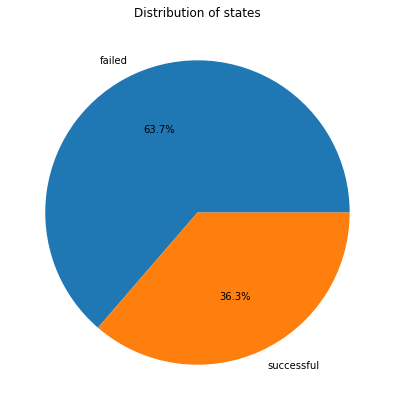

In [16]:
df_state = df[(df["state"] != "undefined")].groupby(["state"])["ID"].nunique()
ax = df_state.plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("Distribution of states")
ax.set_ylabel("")

On average, failed and canceled projects tend to ask for a much higher amount of money than successful ones.

Text(0, 0.5, 'Goal (USD)')

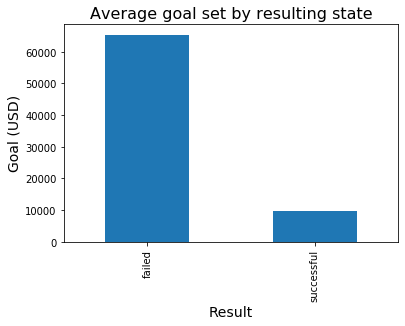

In [17]:
df_goal_state = df.groupby(["state"])["usd_goal_real"].mean()
ax = df_goal_state.plot(kind="bar")
ax.set_title("Average goal set by resulting state", size=16)
ax.set_xlabel("Result", size=14)
ax.set_ylabel("Goal (USD)", size=14)

The bulk of the data has reached 100% of its goal or less. The more successful projects can generate up to 2.5 times the amount they asked for.

There is an non-negligible number of outliers above the upper bound (about 18,000), the best ones having a ridiculously high percentage of success (max = 104,277.89 %). This is typically when the project owner asked only for a low amount of money, like 1 or 10 USD, and then met with tremendous success.

Text(0, 0.5, '% Success')

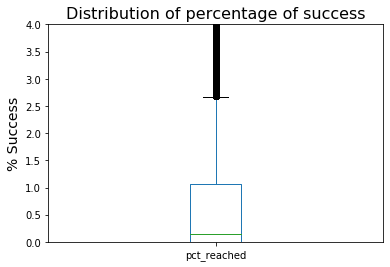

In [18]:
ax = df["pct_reached"].plot(kind="box", ylim=(0,4))
ax.set_title("Distribution of percentage of success", size=16)
ax.set_ylabel("% Success", size=14)

In [19]:
df["pct_reached"].sort_values().tail(10)

164449     16970.86
15288      22603.00
290936     23036.07
369214     24675.00
285408     27588.23
81368      32843.00
76290      41535.01
360721     55266.57
186096     68764.10
369176    104277.89
Name: pct_reached, dtype: float64

In [20]:
df[df["pct_reached"] > 2.7].shape[0]

17496

Close to a third of all projects are either related to the movie or the music industry.

Text(0, 0.5, 'Category')

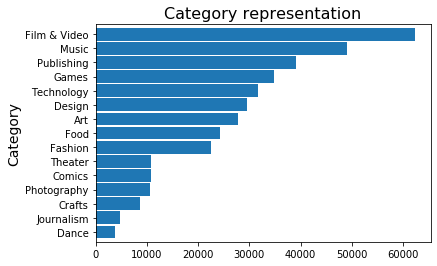

In [21]:
df_main_cat = df.groupby(["main_category"])["ID"].nunique().sort_values(ascending=True)
ax = df_main_cat.plot(kind="barh", x="main_category", width=0.9)
ax.set_title("Category representation", size=16)
ax.set_ylabel("Category", size=14)

In [22]:
print("Percentage of projects in the film and music industries:", (df_main_cat.iloc[-1] + df_main_cat.iloc[-2]) / df.shape[0] * 100)

Percentage of projects in the film and music industries: 30.076252164259532


Non surprisingly, Kickstarter being first and foremost an English-speaking platform, the top 3 most represented countries are the US (by a large margin), the UK and Canada. Then come German and French countries.

Text(0, 0.5, '')

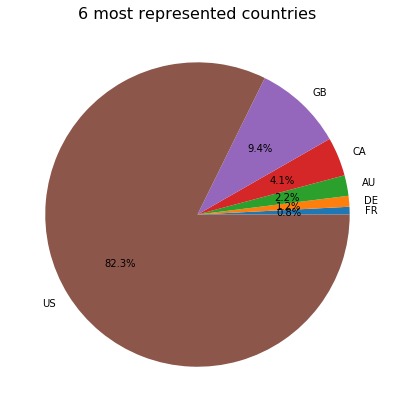

In [23]:
df_country = df.groupby(["country"])["ID"].count().sort_values()
ax = df_country.tail(6).plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("6 most represented countries", size=16)
ax.set_ylabel("")

# EDA BACKERS
Analyse des bakers selon plusieurs paramètre:</br>


1.   Quantité de bakers selon les statuts finaux (mean, max, min, median, mode)
2.   Quantité de bakers selon le type de projet (mean, max, min, median, mode)
3.   Quantité de bakers selon le pays (mean, max, min, median, mode)
4.   etc....




## Value of Bakers depending of the final state

as we can see below, the numbers of backers is pretty random and the spread is really big. 
The number of outliers seem to be really big with a mean at 263, a median at 71 and a mode at 19.


In [31]:
df.groupby(['state'])['backers'].agg(['mean','min','max','median',('mode',lambda x: x.mode()[0])])

,mean,min,max,median,mode
state,,,,,
failed,17.514777,0,9326,3,0
successful,263.704277,1,219382,71,19


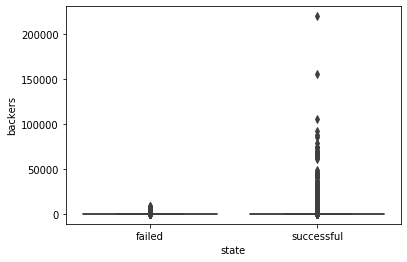

In [43]:
ax = sns.boxplot(x='state', y='backers', data=df)

As we thought the spread is super huge and the number of outliers is super huge too. Then we will represente in the result of the logarithme of those value

## Bakers selon la main_category


In [32]:
df.groupby(['main_category'])['backers'].agg(['mean','min','max','median', ('mode',lambda x: x.mode()[0])])

,mean,min,max,median,mode
main_category,,,,,
Art,42.380267,0,22834,10,0
Comics,135.629198,0,14952,40,0
Crafts,27.629258,0,12705,3,0
Dance,43.097430,0,4133,27,0
Design,241.601762,0,154926,29,0
Fashion,61.903987,0,15129,5,0
Film & Video,67.324706,0,91585,12,0
Food,54.408317,0,13116,6,0
Games,325.606786,0,219382,30,0


##Backer in function of:

the years

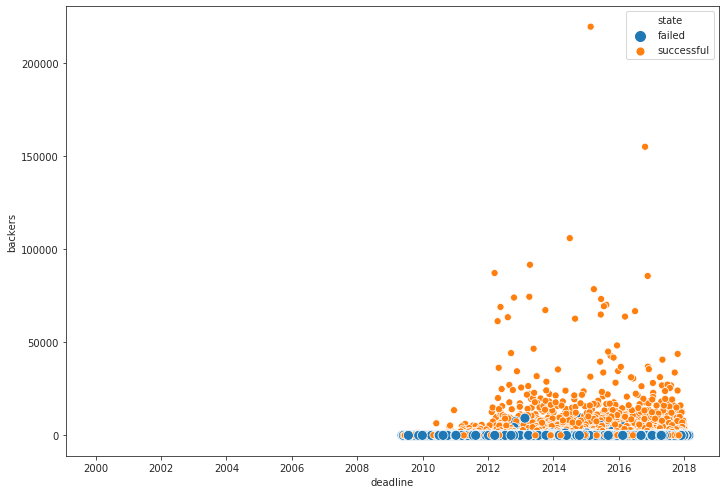

In [66]:
#dfdate =df1[df1["deadline"]>"2005-10-09"]
#sns.jointplot(x="deadline", y="backers", data=df[df["deadline"]>"2005-10-09"])
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="deadline", y="backers", hue='state', size='state', sizes=(50, 100), data=df)

TypeError: ignored

In [0]:
sns.jointplot(x="usd pledged", y="backers", data=df1[df1["usd pledged"]<5000]);

In [0]:

sns.jointplot(x="usd_pledged_real", y="backers", data=df1[df1["usd_pledged_real"]<5000]);

In [0]:
sns.jointplot(x="usd_goal_real", y="backers", data=df1[df1["usd_goal_real"]<5000]);

Do you have good chances of running a successful Kickstarter campaign if you're not from the US/CA?

In [0]:
df_without_na = df[(~df["country"].isin(["US", "CA"]))].groupby(["country"])["pct_reached"].mean().sort_values()
df_without_na
ax = df_without_na.plot(kind="bar", width=0.9)
ax.set_title("Success rate for non-NA countries", size=16)
ax.set_xlabel("Country", size=14)

Which categories are the most successful?

In [0]:
df_success = df[(df["state"] == "successful")].groupby(["main_category"])["ID"].count().sort_values()
ax = df_success.plot(kind="barh", x="main_category", width=0.9)
ax.set_title("Most successful categories", size=16)
ax.set_ylabel("Category", size=14)

How much money is asked for on average by category?

In [0]:
df_avg_goal = df.groupby(["main_category"])["usd_goal_real"].mean().sort_values(ascending=True)
ax = df_avg_goal.plot(kind="barh", width=0.9)
ax.set_title("Average goal (USD) per category", size=16)
ax.set_ylabel("Category", size=14)

Most successful categories in Switzerland? How much money do they ask for on average?

In [0]:
df_switzerland = df[(df["country"] == "CH") & (df["state"] == "successful")].groupby(["main_category"])[["ID", "usd_goal_real"]].agg({"ID":"count", "usd_goal_real":"mean"}).sort_values(by="ID", ascending=False)
df_switzerland.head(5)

# Machine Learning Models

In [0]:
X = df[["usd_goal_real", "usd_pledged_real"]]
y = df["state"]
X.head()

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
from sklearn.linear_model import LogisticRegressionCV
LR = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)

In [0]:
LR.fit(X_train, y_train)

No surprise there. Based on the goal set and the amount pledged, the prediction of whether the project failed or succeeded is obvious.

In [0]:
LR.score(X_test, y_test)

In [0]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(categories="auto")
cat_to_onehot = one_hot.fit_transform(df[["main_category", "country"]]).toarray()
X = pd.DataFrame(cat_to_onehot)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)